<h2 style='color:blue' align='center'>Sports Celebrity Image Classification<h2>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib

In [2]:
path_to_dataset = "./images_dataset/"
path_to_cr_dataset = "./images_dataset/cropped/"

In [3]:
#using the python os module
import os
img_dirs = []
for entry in os.scandir(path_to_dataset):#this will scan all the subdir in the dir which is given above
    if entry.is_dir():
        img_dirs.append(entry.path)#and append all the dir in img_dir

In [4]:
img_dirs

['./images_dataset/cropped',
 './images_dataset/lionel_messi',
 './images_dataset/maria_sharapova',
 './images_dataset/roger_federer',
 './images_dataset/serena_williams',
 './images_dataset/virat_kohli']

In [5]:
import shutil
if os.path.exists(path_to_cr_dataset): #in this line we are using shutil and checking the path exists
    shutil.rmtree(path_to_cr_dataset) #and remove if exists
os.mkdir(path_to_cr_dataset) #create the new folder

In [6]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [7]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+h]
        roi_color = img[y:y+h, x:x+h]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [8]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_dataset + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
            
            cropped_file_name = celebrity_name + str(count) + (".png")
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

cropped
lionel_messi
maria_sharapova
roger_federer
serena_williams
virat_kohli


In [9]:
import numpy as np
import pywt
import cv2

In [10]:
def w2d(img,mode='haar',level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255;
    #compute coefficients
    coeffs = pywt.wavedec2(imArray,mode,level=level)

    #Process Coefficinets
    coeffs_h = list(coeffs)
    coeffs_h [0] *= 0;

    #reconstruction
    imArray_h = pywt.waverec2(coeffs_h,mode);
    imArray_h *= 255;
    imArray_h = np.uint8(imArray_h)

    return imArray_h

In [11]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count+1
class_dict

{'cropped': 0,
 'lionel_messi': 1,
 'maria_sharapova': 2,
 'roger_federer': 3,
 'serena_williams': 4,
 'virat_kohli': 5}

In [12]:
x = []
y = []


for celebrity_name , training_files in celebrity_file_names_dict.items(): # for celebrity name and then all the files in the dic
    for training_image in training_files: # for each image in the images
        img = cv2.imread(training_image) #reading images one by one
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img,(32,32)) #resizing all the images to a same size
        img_har = w2d(img,'db1',5) # wavelenght transformation 
        scalled_imh_har = cv2.resize(img_har,(32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_imh_har.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])

In [13]:
x = np.array(x).reshape(len(x),4096).astype(float)

In [14]:
x.shape

(187, 4096)

Data cleaning process is done. Now we are ready to train our model.


In [15]:
# We will use SVM with rbf kernel tuned with heuristic finetuning
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)

pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])
pipe.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [17]:
print(classification_report(y_test,pipe.predict(x_test)))

              precision    recall  f1-score   support

           1       0.89      0.80      0.84        10
           2       0.89      1.00      0.94         8
           3       0.80      0.67      0.73         6
           4       0.90      0.82      0.86        11
           5       0.86      1.00      0.92        12

    accuracy                           0.87        47
   macro avg       0.87      0.86      0.86        47
weighted avg       0.87      0.87      0.87        47



In [18]:
pipe.score(x_test,y_test)

0.8723404255319149

Let's use GridSearch to try out different models with different paramets. Goal is to come up with best model with best fined tune parameters.

In [19]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['linear','rbf']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [20]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.728571,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.621429,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.707143,{'logisticregression__C': 1}


In [21]:
best_estimators['svm'].score(x_test,y_test)

0.8085106382978723

In [22]:
best_estimators['random_forest'].score(x_test,y_test)

0.6808510638297872

In [23]:
best_estimators['logistic_regression'].score(x_test,y_test)

0.851063829787234

In [24]:
best_clf = best_estimators['svm']

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,best_clf.predict(x_test))
cm

array([[ 7,  0,  1,  1,  1],
       [ 0,  8,  0,  0,  0],
       [ 2,  0,  3,  1,  0],
       [ 0,  1,  0,  9,  1],
       [ 0,  0,  1,  0, 11]], dtype=int64)

Text(69.0, 0.5, 'Truth')

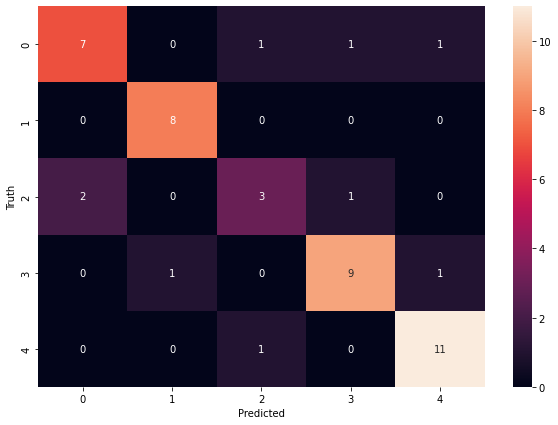

In [26]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Saved train model

In [27]:
import joblib
joblib.dump(best_clf,'svaed_model.pkl')

['svaed_model.pkl']

Saved class dictionary

In [29]:
import json
with open("class_dcitionary.json","w") as f:
    f.write(json.dumps(class_dict))